In [ ]:
!pip install nibabel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


   3875/Unknown 1342s 309ms/step - loss: 0.0266
Epoch 1: saving model to /content/drive/MyDrive/Dataset/checkpoints/model_epoch_01.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Epoch 0: PSNR: 7.42, SSIM: 0.0020


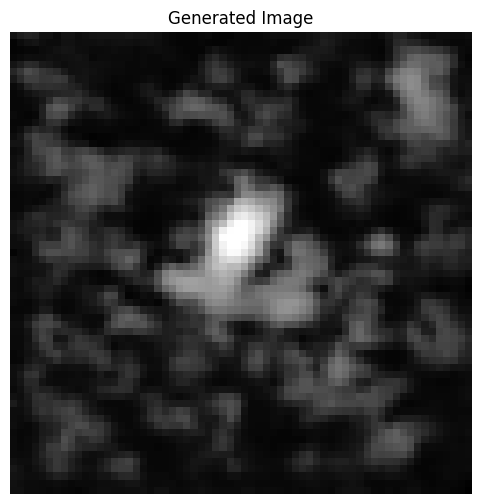

3875/3875 ━━━━━━━━━━━━━━━━━━━━ 1446s 335ms/step - loss: 0.0266
Epoch 2/10
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0133
Epoch 2: saving model to /content/drive/MyDrive/Dataset/checkpoints/model_epoch_02.keras
Epoch 1: PSNR: 6.71, SSIM: -0.0033


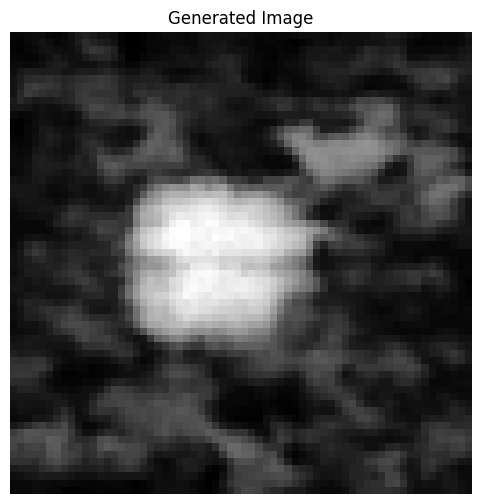

3875/3875 ━━━━━━━━━━━━━━━━━━━━ 1324s 332ms/step - loss: 0.0133
Epoch 3/10
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0126
Epoch 3: saving model to /content/drive/MyDrive/Dataset/checkpoints/model_epoch_03.keras
Epoch 2: PSNR: 6.93, SSIM: -0.0000


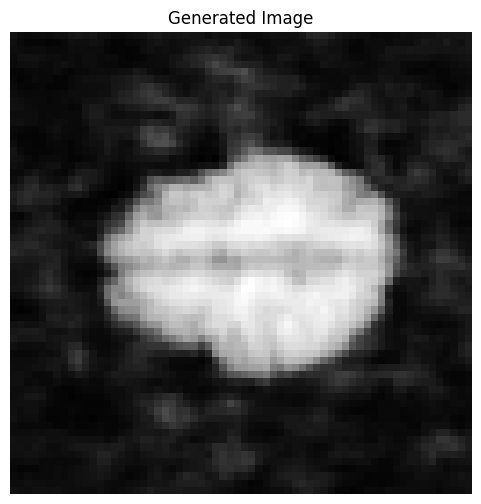

3875/3875 ━━━━━━━━━━━━━━━━━━━━ 1337s 331ms/step - loss: 0.0126
Epoch 4/10
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0124
Epoch 4: saving model to /content/drive/MyDrive/Dataset/checkpoints/model_epoch_04.keras
Epoch 3: PSNR: 9.41, SSIM: 0.0025


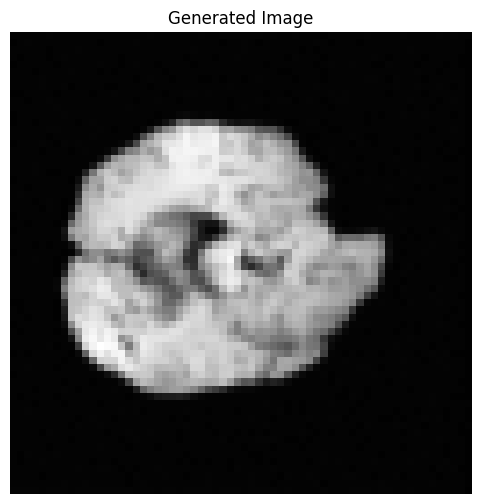

3875/3875 ━━━━━━━━━━━━━━━━━━━━ 1347s 332ms/step - loss: 0.0124
Epoch 5/10
1294/3875 ━━━━━━━━━━━━━━━━━━━━ 13:17 309ms/step - loss: 0.0114

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =============================================================================
# Hyperparameters and settings
# =============================================================================
batch_size = 8
num_epochs = 20
steps_per_epoch = 25
total_timesteps = 500
norm_groups = 8
learning_rate = 2e-4

img_size = 64
input_channels = 2
output_channels = 1

clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2

# =============================================================================
# Data Generator
# =============================================================================
def generate_training_slices(root_dir):
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            gt_file = os.path.join(folder_path, f"{folder}-t1n.nii.gz")
            voided_file = os.path.join(folder_path, f"{folder}-t1n-voided.nii.gz")
            mask_file = os.path.join(folder_path, f"{folder}-mask.nii.gz")
            if os.path.exists(gt_file) and os.path.exists(voided_file) and os.path.exists(mask_file):
                gt_nii = nib.load(gt_file)
                voided_nii = nib.load(voided_file)
                mask_nii = nib.load(mask_file)
                gt_data = gt_nii.get_fdata()
                voided_data = voided_nii.get_fdata()
                mask_data = mask_nii.get_fdata()
                for i in range(gt_data.shape[2]):
                    gt_slice = gt_data[:, :, i]
                    voided_slice = voided_data[:, :, i]
                    mask_slice = mask_data[:, :, i]

                    min_val = gt_slice.min()
                    max_val = gt_slice.max()
                    if max_val > min_val:
                        gt_slice = (gt_slice - min_val) / (max_val - min_val)
                    else:
                        gt_slice = np.zeros_like(gt_slice)
                    gt_slice = gt_slice * 2.0 - 1.0

                    min_val_v = voided_slice.min()
                    max_val_v = voided_slice.max()
                    if max_val_v > min_val_v:
                        voided_slice = (voided_slice - min_val_v) / (max_val_v - min_val_v)
                    else:
                        voided_slice = np.zeros_like(voided_slice)
                    voided_slice = voided_slice * 2.0 - 1.0

                    mask_slice = (mask_slice > 0).astype(np.float32)

                    gt_slice = np.expand_dims(gt_slice, axis=-1)
                    voided_slice = np.expand_dims(voided_slice, axis=-1)
                    mask_slice = np.expand_dims(mask_slice, axis=-1)
                    yield voided_slice, mask_slice, gt_slice

root_dir = "/content/drive/MyDrive/Dataset/SampleTraining/"
ds = tf.data.Dataset.from_generator(
    lambda: generate_training_slices(root_dir),
    output_types=(tf.float32, tf.float32, tf.float32),
    output_shapes=((240, 240, 1), (240, 240, 1), (240, 240, 1))
)

# =============================================================================
# Preprocessing Functions
# =============================================================================
def resize_and_rescale(img, size):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)
    img = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    img = tf.image.resize(img, size=size, method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    img = tf.cast(img, dtype=tf.float32)
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img

def augment(stacked):
    return tf.image.random_flip_left_right(stacked)

def preprocess_fn(corrupted, mask, gt):
    corrupted = resize_and_rescale(corrupted, size=(img_size, img_size))
    mask = tf.image.crop_to_bounding_box(
        mask,
        (tf.shape(mask)[0] - tf.minimum(tf.shape(mask)[0], tf.shape(mask)[1])) // 2,
        (tf.shape(mask)[1] - tf.minimum(tf.shape(mask)[0], tf.shape(mask)[1])) // 2,
        tf.minimum(tf.shape(mask)[0], tf.shape(mask)[1]),
        tf.minimum(tf.shape(mask)[0], tf.shape(mask)[1])
    )
    mask = tf.image.resize(mask, size=(img_size, img_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, dtype=tf.float32)
    mask = tf.clip_by_value(mask, 0.0, 1.0)
    gt = resize_and_rescale(gt, size=(img_size, img_size))
    stacked = tf.concat([corrupted, mask, gt], axis=-1)
    stacked = augment(stacked)
    corrupted, mask, gt = stacked[..., :1], stacked[..., 1:2], stacked[..., 2:3]
    return corrupted, mask, gt

train_ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(batch_size * 2).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# =============================================================================
# Gaussian Diffusion Utilities
# =============================================================================
class GaussianDiffusion:
    def __init__(self, beta_start=1e-4, beta_end=0.02, timesteps=1000, clip_min=-1.0, clip_max=1.0):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max
        betas = np.linspace(beta_start, beta_end, timesteps, dtype=np.float64)
        self.num_timesteps = int(timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)
        self.sqrt_alphas_cumprod = tf.constant(np.sqrt(alphas_cumprod), dtype=tf.float32)
        self.sqrt_one_minus_alphas_cumprod = tf.constant(np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32)
        self.log_one_minus_alphas_cumprod = tf.constant(np.log(1.0 - alphas_cumprod), dtype=tf.float32)
        self.sqrt_recip_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32)
        self.sqrt_recipm1_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32)
        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)
        self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32)
        self.posterior_mean_coef1 = tf.constant(betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod), dtype=tf.float32)
        self.posterior_mean_coef2 = tf.constant((1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod), dtype=tf.float32)

    def _extract(self, a, t, x_shape):
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        x_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_shape)
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        x_shape = tf.shape(x_start)
        return (self._extract(self.sqrt_alphas_cumprod, t, x_shape) * x_start +
                self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_shape) * noise)

    def predict_start_from_noise(self, x_t, t, noise):
        x_shape = tf.shape(x_t)
        return (self._extract(self.sqrt_recip_alphas_cumprod, t, x_shape) * x_t -
                self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_shape) * noise)

    def q_posterior(self, x_start, x_t, t):
        x_shape = tf.shape(x_t)
        posterior_mean = (self._extract(self.posterior_mean_coef1, t, x_shape) * x_start +
                          self._extract(self.posterior_mean_coef2, t, x_shape) * x_t)
        posterior_variance = self._extract(self.posterior_variance, t, x_shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)
        model_mean, _, model_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, None, model_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        model_mean, _, model_log_variance = self.p_mean_variance(pred_noise, x=x, t=t, clip_denoised=clip_denoised)
        noise = tf.random.normal(shape=tf.shape(x), dtype=x.dtype)
        nonzero_mask = tf.reshape(1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1])
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

# =============================================================================
# Model Building (UNet with Attention and Time Embedding)
# =============================================================================
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(scale, mode="fan_avg", distribution="uniform")

class AttentionBlock(layers.Layer):
    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)
        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)
        x_norm = self.norm(inputs)
        q = self.query(x_norm)
        k = self.key(x_norm)
        v = self.value(x_norm)
        attn = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn = tf.reshape(attn, [batch_size, height, width, height * width])
        attn = tf.nn.softmax(attn, axis=-1)
        attn = tf.reshape(attn, [batch_size, height, width, height, width])
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn, v)
        proj = self.proj(proj)
        return inputs + proj

class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        if x.shape[-1] == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1, kernel_initializer=kernel_init(1.0))(x)
        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[:, None, None, :]
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0))(x)
        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0))(x)
        x = layers.Add()([x, residual])
        return x
    return apply

def DownSample(width):
    def apply(x):
        return layers.Conv2D(width, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_init(1.0))(x)
    return apply

def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        return layers.Conv2D(width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0))(x)
    return apply

def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(units, activation=activation_fn, kernel_initializer=kernel_init(1.0))(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb
    return apply

def build_model(img_size, input_channels, widths, has_attention, num_res_blocks=2, norm_groups=8,
                interpolation="nearest", activation_fn=keras.activations.swish):
    image_input = layers.Input(shape=(img_size, img_size, input_channels), name="image_input")
    time_input = layers.Input(shape=(), dtype=tf.int64, name="time_input")
    x = layers.Conv2D(first_conv_channels, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0))(image_input)
    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)
    skips = [x]
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)
        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(output_channels, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

# =============================================================================
# Diffusion Model with Inpainting
# =============================================================================
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, data):
        corrupted, mask, gt = data
        batch_size = tf.shape(gt)[0]
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)
        noise = tf.random.normal(shape=tf.shape(gt), dtype=gt.dtype)
        x_t = self.gdf_util.q_sample(gt, t, noise)
        x_t_cond = mask * corrupted + (1 - mask) * x_t
        net_input = tf.concat([x_t_cond, mask], axis=-1)
        pred_noise = self.network([net_input, t], training=True)
        loss = self.compiled_loss((1 - mask) * noise, (1 - mask) * pred_noise)
        gradients = tf.gradients(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)
        return {"loss": loss}

    def generate_images(self, corrupted, mask):
        samples = tf.random.normal(shape=tf.shape(corrupted), dtype=tf.float32)
        samples = mask * corrupted + (1 - mask) * samples
        batch_size = tf.shape(corrupted)[0]
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill([batch_size], t), dtype=tf.int64)
            net_input = tf.concat([samples, mask], axis=-1)
            pred_noise = self.ema_network.predict([net_input, tt], verbose=0, batch_size=batch_size)
            samples = self.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)
            samples = mask * corrupted + (1 - mask) * samples
        return samples

    def plot_images(self, epoch=None, logs=None, figsize=(6, 6)):
        for corrupted, mask, gt in train_ds.take(1):
            inpainted = self.generate_images(corrupted, mask)
            inpainted_disp = tf.clip_by_value(inpainted * 127.5 + 127.5, 0, 255)
            gt_disp = tf.clip_by_value(gt * 127.5 + 127.5, 0, 255)
            inpainted_disp = tf.cast(inpainted_disp, tf.float32)
            gt_disp = tf.cast(gt_disp, tf.float32)
            psnr_values = tf.image.psnr(inpainted_disp, gt_disp, max_val=255)
            ssim_values = tf.image.ssim(inpainted_disp, gt_disp, max_val=255)
            psnr_val = psnr_values[0]
            ssim_val = ssim_values[0]
            print(f"Epoch {epoch}: PSNR: {psnr_val.numpy():.2f}, SSIM: {ssim_val.numpy():.4f}")
            plt.figure(figsize=figsize)
            plt.imshow(inpainted_disp[0, ..., 0].numpy().astype(np.uint8), cmap="gray")
            plt.title(f"Generated Image")
            plt.axis("off")
            plt.show()
            break

# =============================================================================
# Build and Compile the Model
# =============================================================================
network = build_model(img_size=img_size, input_channels=input_channels, widths=widths,
                      has_attention=has_attention, num_res_blocks=num_res_blocks, norm_groups=norm_groups,
                      activation_fn=keras.activations.swish)
ema_network = build_model(img_size=img_size, input_channels=input_channels, widths=widths,
                          has_attention=has_attention, num_res_blocks=num_res_blocks, norm_groups=norm_groups,
                          activation_fn=keras.activations.swish)
ema_network.set_weights(network.get_weights())

gdf_util = GaussianDiffusion(timesteps=total_timesteps, clip_min=clip_min, clip_max=clip_max)

model = DiffusionModel(network=network, ema_network=ema_network, gdf_util=gdf_util, timesteps=total_timesteps)
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

# =============================================================================
# Train the Model
# =============================================================================
model.fit(
    train_ds,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images)]
)